# Отток клиентов

Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Мы располагаем историческими данными о поведении клиентов и расторжении договоров с банком. 

Наша задача — построить модель со значеним *F1*-меры не менее 0,59.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Основными этапами нашего проекта станут:  
* Подготовка данных
* Исследование задачи. Обучение разных моделей без учета дисбаланса
* Борьба с дисбалансом. Обучение разных моделей с учетом дисбаланса
* Тестирование модели
* Проверка модели на вменяемость
* Исследование метрики AUC-ROC

**Описание данных**  

**Признаки**

*RowNumber* — индекс строки в данных  
*CustomerId* — уникальный идентификатор клиента  
*Surname* — фамилия  
*CreditScore* — кредитный рейтинг  
*Geography* — страна проживания  
*Gender* — пол  
*Age* — возраст  
*Tenure* — сколько лет человек является клиентом банка  
*Balance* — баланс на счёте  
*NumOfProducts* — количество продуктов банка, используемых клиентом  
*HasCrCard* — наличие кредитной карты  
*IsActiveMember* — активность клиента  
*EstimatedSalary* — предполагаемая зарплата

**Целевой признак** 

**Exited** — факт ухода клиента


Проект выполнен в **Jupyter Notebook**, версия сервера блокнотов: 6.1.4. Версия **Python** 3.7.8.  
  
В проекте использованы библиотеки:
* **Pandas**
* **NumPy**
* **MatPlotLib**
* **scikit-learn** 
* **IPython** 

## Подготовка данных

In [1]:
# Импортируем все необходимые для работы библиотеки и модули.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

# Прочитаем данные. Сохраним их в переменной data.
data = pd.read_csv('/datasets/Churn.csv', index_col=0)
display(data.head(5))

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [2]:
# Гораздо удобнее, когда названия столбцов
# написаны прописными буквами. Поменяем высоту букв.
data.columns = data.columns.str.lower()
# Для удобства переведем формат данных признака Tenure в Int64.
# Такой формат позволяет избавиться от ненужного отображения числа 
# с плавающей запятой, а также оставить пропуски (NaN-значения).
data.tenure = data.tenure.astype('Int64')
# Изучим общую информацию о датасете.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       10000 non-null  int64  
 1   surname          10000 non-null  object 
 2   creditscore      10000 non-null  int64  
 3   geography        10000 non-null  object 
 4   gender           10000 non-null  object 
 5   age              10000 non-null  int64  
 6   tenure           9091 non-null   Int64  
 7   balance          10000 non-null  float64
 8   numofproducts    10000 non-null  int64  
 9   hascrcard        10000 non-null  int64  
 10  isactivemember   10000 non-null  int64  
 11  estimatedsalary  10000 non-null  float64
 12  exited           10000 non-null  int64  
dtypes: Int64(1), float64(2), int64(7), object(3)
memory usage: 1.1+ MB


In [3]:
# Признак tenure обладает объектами с NaN-значениями. 
# Это помешает обучению нашей модели.
# Корректно заполнить пропуски не удастся. 
# Удалим строки, содержащие пропуски.
data = data.dropna().reset_index(drop=True)
# Проверим, имеет ли датасет полные дубликаты.
print('Количество полных дубликатов в датасете', 
      data.duplicated().sum())
# Столбцы с признаками customerid и surname 
# не имеют смысла для машинного обучения.
# Избавимся от них.
data = data.drop(['customerid', 'surname'], axis=1)
display(data)

Количество полных дубликатов в датасете 0


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9086,800,France,Female,29,2,0.00,2,0,0,167773.55,0
9087,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9088,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9089,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [4]:
# В датафрейме есть как количественные, так и категоральные признаки. 
# Воспользуемся техникой прямого кодирования.
data_ohe = pd.get_dummies(data, drop_first=True)
display(data_ohe.head(5))
data_ohe.info()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   creditscore        9091 non-null   int64  
 1   age                9091 non-null   int64  
 2   tenure             9091 non-null   Int64  
 3   balance            9091 non-null   float64
 4   numofproducts      9091 non-null   int64  
 5   hascrcard          9091 non-null   int64  
 6   isactivemember     9091 non-null   int64  
 7   estimatedsalary    9091 non-null   float64
 8   exited             9091 non-null   int64  
 9   geography_Germany  9091 non-null   uint8  
 10  geography_Spain    9091 non-null   uint8  
 11  gender_Male        9091 non-null   uint8  
dtypes: Int64(1), float64(2), int64(6), uint8(3)
memory usage: 674.8 KB


In [5]:
# Подготовим тренировочный, валидационный и тестовый наборы.
features = data_ohe.drop('exited', axis=1)
target = data_ohe.exited

В методе `train_test_split` используем параметр `stratify`. Укажем в нём набор объектов целевого признака. Это позволит сохранить соотношение объектов разных классов в разбитых наборах таким же, как и в наборе `target`.

In [6]:
# Сначала поделим на тренировочный и валидационный. 
# Размер валидационной выборки 0.2.
features_train, features_valid, target_train, target_valid = train_test_split(
    features,
    target, 
    test_size=.2,
    random_state=12345,
    stratify=target
)
# Теперь разделим тренировочную выборку на тестовую и 
# окончательный вариант тренировочной выборки.
features_train, features_test, target_train, target_test = train_test_split(
    features_train,
    target_train, 
    test_size=.25,
    random_state=12345,
    stratify=target_train
)

In [7]:
# Масштабируем численные количественные признаки.
numeric_features = [
    'creditscore', 
    'age', 
    'tenure', 
    'balance', 
    'estimatedsalary'
]
scaler = StandardScaler()
scaler.fit(features_train[numeric_features]) 
features_train[numeric_features] = scaler.transform(
    features_train[numeric_features]
)
features_valid[numeric_features] = scaler.transform(
    features_valid[numeric_features]
)
features_test[numeric_features] = scaler.transform(
    features_test[numeric_features]
)
pd.options.mode.chained_assignment = None
display(features_train.head(5))
# Выборки готовы. Взглянем на их размеры. 
# Мы помним, что изначальный набор данных имел 
# 13 признаков и 9091 объектов.
samples = [
    features_train, target_train, 
    features_valid, target_valid, 
    features_test, target_test
]
for sample in samples:
    display(sample.shape)

/tmp/ipykernel_136/642549314.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[numeric_features] = scaler.transform(
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_Germany,geography_Spain,gender_Male
2804,0.273332,-1.028943,-0.344468,-1.224804,2,1,1,0.776365,0,0,0
4445,0.867258,0.197898,0.688936,1.669480,1,1,1,0.650528,0,0,1
8537,-0.133038,-0.745826,-0.688936,0.357605,1,0,0,-1.368629,0,0,0
1588,-1.362568,-0.085219,0.000000,0.555184,1,0,1,0.638830,0,0,1
5744,0.867258,1.047250,-1.033403,-1.224804,2,0,1,0.822454,0,0,1


(5454, 11)

(5454,)

(1819, 11)

(1819,)

(1818, 11)

(1818,)

### Вывод

Нами были подготовлены данные:  
* Для удобства написания кода была уменьшена высота букв в названиях признаков  
* Формат данных столбца *tenure* переведен в `int64`. Это позволило избавиться от не имеющей смысла плавающей запятой
* В связи с невозможностью корректного заполнения пропущенных объектов с признаке *tenure*, было принято решение избавиться от строк с пропусками. Наличие пропусков помешает корректному обучению математической модели.  
* Мы провели проверку на наличие полных дубликатов. Полные дубликаты отсутствуют.
* В связи с тем, что необходимость в данных, указанных в признаках *customerid* и *surname*, отсутствует, мы избавились от них, удалив их из датасета
* При помощи техники прямого кодирования мы перевели категоральные признаки, выраженные словами, в численные  
* При помощи метода `train_test_split` мы поделили выборку на три набора: тренировочный, валидационный и тестовый в классическом соотношении: 0,6 / 0,2 / 0,2  
* При помощи метода `scaler.transform` проведено масштабирование численных признаков *creditscore*, *age*, *tenure*, *balance*, *estimatedsalary*  
* Для самопроверки оценены размеры выборок

## Исследование задачи. Обучение разных моделей без учета дисбаланса

0    0.796113
1    0.203887
Name: exited, dtype: float64

<AxesSubplot:>

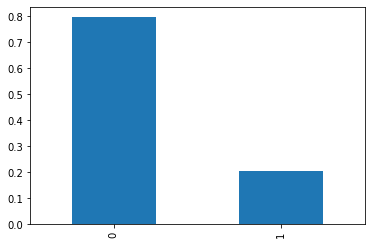

In [8]:
# Оценим соотношение классов.
display(target_train.value_counts(normalize=True))
target_train.value_counts(normalize=True).plot(kind='bar')

Accuracy модели логистической регрессии до балансирования классов составляет 0.8136338647608576
Accuracy константной dummy-модели составляет 0.7960620393796062

Матрица ошибок
[[1393   55]
 [ 284   87]]

Recall модели логистической регрессии до балансирования классов составляет 0.23450134770889489
Precision модели логистической регрессии до балансирования классов составляет 0.6126760563380281
F1-мера модели логистической регрессии до балансирования классов составляет 0.33918128654970764



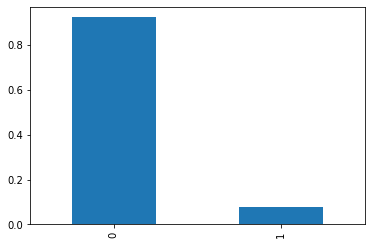

In [9]:
# Обучим разные модели без учета дисбаланса классов
# Начнем с логистической регрессии.
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid = pd.Series(model_lr.predict(features_valid))
predicted_valid.value_counts(normalize=True).plot(kind='bar')
# Посчитаем значение accuracy.
accuracy_valid =  accuracy_score(target_valid, predicted_valid)
print('Accuracy модели логистической регрессии' + 
      ' до балансирования классов составляет', accuracy_valid)
# Проверим модель на адекватность. Создадим константную модель.
dummy_regr = DummyRegressor(strategy="constant", constant=0)
dummy_regr.fit(features, target)
target_pred_constant = pd.Series(dummy_regr.predict(features))
print('Accuracy константной dummy-модели составляет', 
      accuracy_score(target, target_pred_constant))
print()
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall модели логистической регрессии' + 
      ' до балансирования классов составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision модели логистической регрессии' +
      ' до балансирования классов составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера модели логистической регрессии' +
      ' до балансирования классов составляет', 
      f1_score(target_valid, predicted_valid))
print()

In [10]:
# Обучим решающее дерево без учета дисбаланса. 
# Сначала настроим гиперпараметр max_depth.
for depth in range(1, 11):
    model_dt = DecisionTreeClassifier(
        random_state=12345, max_depth=depth
    ) 
    model_dt.fit(features_train, target_train)
    predictions_valid = model_dt.predict(features_valid)
    print('max_depth =', depth, ': ', end='')
    print(accuracy_score(target_valid, predictions_valid))
# Теперь обучиим решающее дерево.
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=5) 
model_dt.fit(features_train, target_train)
predicted_valid = model_dt.predict(features_valid)
accuracy_valid =  accuracy_score(target_valid, predicted_valid)
print('Accuracy модели решающего дерева' +
      ' до балансирования классов составляет', accuracy_valid)
# Проверим модель на адекватность. Создадим константную модель.
dummy_dt = DummyClassifier(strategy="constant", constant=0)
dummy_dt.fit(features, target)
target_pred_dt = pd.Series(dummy_dt.predict(features))
print('Accuracy константной dummy-модели составляет', 
      accuracy_score(target, target_pred_dt))
print()
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall модели решающего дерева' +
      ' до балансирования классов составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision модели решающего дерева' +
      ' до балансирования классов составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера модели решающего дерева' +
      ' до балансирования классов составляет', 
      f1_score(target_valid, predicted_valid))
print()

max_depth = 1 : 0.7960417811984607
max_depth = 2 : 0.8367234744365035
max_depth = 3 : 0.8427707531610775
max_depth = 4 : 0.8510170423309511
max_depth = 5 : 0.8587135788894997
max_depth = 6 : 0.8581638262781748
max_depth = 7 : 0.8510170423309511
max_depth = 8 : 0.8499175371083013
max_depth = 9 : 0.8367234744365035
max_depth = 10 : 0.8152831225948324
Accuracy модели решающего дерева до балансирования классов составляет 0.8587135788894997
Accuracy константной dummy-модели составляет 0.7960620393796062

Матрица ошибок
[[1421   27]
 [ 230  141]]

Recall модели решающего дерева до балансирования классов составляет 0.38005390835579517
Precision модели решающего дерева до балансирования классов составляет 0.8392857142857143
F1-мера модели решающего дерева до балансирования классов составляет 0.5231910946196661



In [11]:
# Обучим случайный лес. 
# Сначала настроим гиперпараметр n_estimators.
best_model = None
best_result = 0
for est in range(1, 41):
    model = RandomForestClassifier(
        random_state=12345, 
        n_estimators=est
    )
    model.fit(features_train, target_train)
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
    print(est, best_result)
print('Accuracy наилучшей модели на валидационной выборке:', 
      best_result)
print()
# Обучим модель.
model_rf = RandomForestClassifier(
    random_state=12345, n_estimators=38
) 
model_rf.fit(features_train, target_train)
predicted_valid = model_rf.predict(features_valid)
accuracy_valid =  accuracy_score(target_valid, predicted_valid)
print('Accuracy нашей модели до балансирования классов составляет', 
      accuracy_valid)
# Проверим модель на адекватность. Создадим константную модель.
dummy_rf = DummyClassifier(strategy="constant", constant=0)
dummy_rf.fit(features, target)
target_pred_rf = pd.Series(dummy_rf.predict(features))
print('Accuracy константной dummy-модели составляет', 
      accuracy_score(target, target_pred_rf))
print()
# Посчитаем основные метрики
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели до балансирования' +
      ' классов составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели до балансирования' + 
      ' классов составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели до балансирования' +
      ' классов составляет', 
      f1_score(target_valid, predicted_valid))
print()

1 0.7932930181418362
2 0.8295766904892798
3 0.8295766904892798
4 0.8433205057724025
5 0.8433205057724025
6 0.8433205057724025
7 0.8433205057724025
8 0.8444200109950523
9 0.8444200109950523
10 0.8499175371083013
11 0.8499175371083013
12 0.8532160527762507
13 0.8532160527762507
14 0.8532160527762507
15 0.8532160527762507
16 0.8532160527762507
17 0.8532160527762507
18 0.8548653106102254
19 0.8548653106102254
20 0.8559648158328752
21 0.8559648158328752
22 0.857064321055525
23 0.857064321055525
24 0.8581638262781748
25 0.8581638262781748
26 0.8581638262781748
27 0.8581638262781748
28 0.8581638262781748
29 0.8581638262781748
30 0.8581638262781748
31 0.8581638262781748
32 0.8581638262781748
33 0.8581638262781748
34 0.8581638262781748
35 0.8581638262781748
36 0.8581638262781748
37 0.8581638262781748
38 0.8598130841121495
39 0.8598130841121495
40 0.8598130841121495
Accuracy наилучшей модели на валидационной выборке: 0.8598130841121495

Accuracy нашей модели до балансирования классов составляет 

### Вывод

Мы оценили соотношение классов тренировочной выборки: отрицательный класс встречается в 4 раза чаще, чем положительный. Такое же соотношение наблюдается в валидационном наборе. Можно сделать вывод о наличии дисбаланса классов.  
  
Без учета дисбаланса классов были обучены три разные модели с тремя разными алгоритмами:  
  
**Логистическая регрессия**  
Accuracy нашей модели составила 0,81. При этом accuracy константной dummy-модели — 0,8. Accuracy нашей модели практически равна accuracy модели-пустышки. Данные результаты говорят о невменяемости нашей модели.  
Recall составила 0,23  
Precision составила 0,61  
F1-мера составила 0,34  
  
**Решающее дерево**  
Accuracy нашей модели составила 0,86. При этом accuracy константной dummy-модели — 0,8. Accuracy нашей модели незначительно выше модели-пустышки.  
Recall составила 0,38  
Precision составила 0,84  
F1-мера составила 0,52  
  
**Случайный лес**  
Accuracy нашей модели составила 0,86. При этом accuracy константной dummy-модели — 0,8. Accuracy нашей модели незначительно выше модели-пустышки.  
Recall составила 0,48  
Precision составила 0,74  
F1-мера составила 0,58 
  
**Для повышения ключевой метрики, F1-меры, нам необходимо провести балансировку классов. Этому мы посвятим следующий шаг проекта.**

## Борьба с дисбалансом. Обучение разных моделей с учетом дисбаланса

### Логистическая регрессия

#### Метод № 1: использование параметра class_weight

In [12]:
# Начнем нашу борьбу с дисбалансом. Обучим модель 
# с алгоритмом логистической регрессии.
# Не забудем в параметре class_weight указать balanced.
model_lr_2 = LogisticRegression(
    random_state=12345, 
    solver='liblinear', 
    class_weight='balanced'
)
model_lr_2.fit(features_train, target_train)
predicted_valid = model_lr_2.predict(features_valid)
# Посчитаем основные метрики
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования классов составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования классов составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования классов составляет', 
      f1_score(target_valid, predicted_valid))

Матрица ошибок
[[1021  427]
 [ 113  258]]

Recall нашей модели после балансирования классов составляет 0.6954177897574124
Precision нашей модели после балансирования классов составляет 0.37664233576642336
F1-мера нашей модели после балансирования классов составляет 0.48863636363636365


#### Метод № 2: увеличение выборки Upsampling

In [13]:
# Воспользуемся методом увеличения выборки 
# за счет увеличения количества
# объектов признаков класса, встречающегося реже.
# Напишем функцию upsample, принимающую на вход 
# целевой и остальные признаки, а также множитель.
def upsample(features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    
    features_upsampled = pd.concat(
        [features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat(
        [target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

# Получим новые выборки.
features_upsampled, target_upsampled = upsample(
    features_train, 
    target_train,
    4
)
# Проверим их размеры.
print(features_upsampled.shape)
print(target_upsampled.shape)
print()
print(target_upsampled.value_counts())
print()
# Создадим модель и обучим её.
model_lr_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_3.fit(features_upsampled, target_upsampled)
predicted_valid = model_lr_3.predict(features_valid)
# Посчитаем основные метрики
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования' +
      ' классов методом Upsampling составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования' + 
      ' классов методом Upsampling составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования' + 
      ' классов методом Upsampling составляет', 
      f1_score(target_valid, predicted_valid))

(8790, 11)
(8790,)

1    4448
0    4342
Name: exited, dtype: int64

Матрица ошибок
[[1007  441]
 [ 111  260]]

Recall нашей модели после балансирования классов методом Upsampling составляет 0.7008086253369272
Precision нашей модели после балансирования классов методом Upsampling составляет 0.37089871611982883
F1-мера нашей модели после балансирования классов методом Upsampling составляет 0.48507462686567165


#### Метод № 3: уменьшение выборки Downsampling

In [14]:
# Воспользуемся методом уменьшения выборки 
# за счет уменьшения количества объектов признаков 
# класса, встречающегося чаще.
# Напишем функцию downsample, принимающую на вход 
# целевой и остальные признаки, а также множитель.
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + 
        [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + 
        [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

# Получим новые выборки.
features_downsampled, target_downsampled = downsample(
    features_train, target_train, 0.25
)
# Проверим их размеры.
print(features_downsampled.shape)
print(target_downsampled.shape)
print()
print(target_downsampled.value_counts())
print()
# Создадим модель и обучим её.
model_lr_4 = LogisticRegression(random_state=12345, solver='liblinear')
model_lr_4.fit(features_downsampled, target_downsampled)
predicted_valid = model_lr_4.predict(features_valid)
# Посчитаем основные метрики
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования' + 
      ' классов методом методом Downsampling составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования' +
      ' классов методом методом Downsampling составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования' +
      ' классов методом методом Downsampling составляет', 
      f1_score(target_valid, predicted_valid))

(2198, 11)
(2198,)

1    1112
0    1086
Name: exited, dtype: int64

Матрица ошибок
[[1016  432]
 [ 115  256]]

Recall нашей модели после балансирования классов методом методом Downsampling составляет 0.6900269541778976
Precision нашей модели после балансирования классов методом методом Downsampling составляет 0.37209302325581395
F1-мера нашей модели после балансирования классов методом методом Downsampling составляет 0.48347497639282344


#### Вывод

Значения F1-меры модели логистической регрессии для каждого способа борьбы с дисбалансом составили:  
* Использование параметра class_weight = 'balanced': F1-мера равна 0,489
* Применение техники Upsampling: F1-мера равна 0,485
* Применение техники Downsampling: F1-мера равна 0,483  

Балансировка обучающего набора данных позволила значительно увеличить F1-меру, каким бы способом мы ни боролись с дисбалансом. Однако добиться поставленной задачи (F1-меры со значением не менее 0,59) нам не удалось. Попробуем применить другие алгоритмы.

### Решающее дерево

#### Метод № 1: использование параметра class_weight

In [15]:
# Обучим модель с алгоритмом решающего дерева
# Не забудем в параметре class_weight указать balanced.
model_dt_2 = DecisionTreeClassifier(
    random_state=12345, 
    max_depth=6, 
    class_weight='balanced'
) 
model_dt_2.fit(features_train, target_train)
predicted_valid = model_dt_2.predict(features_valid)
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования' +
      ' классов составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования' +
      ' классов составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования' +
      ' классов составляет', 
      f1_score(target_valid, predicted_valid))

Матрица ошибок
[[1044  404]
 [  76  295]]

Recall нашей модели после балансирования классов составляет 0.7951482479784366
Precision нашей модели после балансирования классов составляет 0.4220314735336195
F1-мера нашей модели после балансирования классов составляет 0.5514018691588786


#### Метод № 2: увеличение выборки Upsampling

In [16]:
# Воспользуемся методом увеличения выборки 
# за счет увеличения количества объектов 
# признаков класса, встречающегося реже.
model_dt_3 = DecisionTreeClassifier(
    random_state=12345, 
    max_depth=6
) 
model_dt_3.fit(features_upsampled, target_upsampled)
predicted_valid = model_dt_3.predict(features_valid)
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования' +
      ' классов методом Upsampling составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования' +
      ' классов методом Upsampling составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования' +
      ' классов методом Upsampling составляет', 
      f1_score(target_valid, predicted_valid))

Матрица ошибок
[[1044  404]
 [  76  295]]

Recall нашей модели после балансирования классов методом Upsampling составляет 0.7951482479784366
Precision нашей модели после балансирования классов методом Upsampling составляет 0.4220314735336195
F1-мера нашей модели после балансирования классов методом Upsampling составляет 0.5514018691588786


#### Метод № 3: уменьшение выборки Downsampling

In [17]:
# Воспользуемся методом уменьшения выборки за счет уменьшения количества 
# объектов признаков класса, встречающегося чаще.
model_dt_4 = DecisionTreeClassifier(
    random_state=12345, 
    max_depth=6
) 
model_dt_4.fit(features_downsampled, target_downsampled)
predicted_valid = model_dt_4.predict(features_valid)
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования' + 
      ' классов методом методом Downsampling составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования' +
      ' классов методом методом Downsampling составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования' + 
      ' классов методом методом Downsampling составляет', 
      f1_score(target_valid, predicted_valid))

Матрица ошибок
[[1056  392]
 [  86  285]]

Recall нашей модели после балансирования классов методом методом Downsampling составляет 0.7681940700808625
Precision нашей модели после балансирования классов методом методом Downsampling составляет 0.42097488921713444
F1-мера нашей модели после балансирования классов методом методом Downsampling составляет 0.5438931297709922


#### Вывод

Значения F1-меры модели решающего дерева для каждого способа борьбы с дисбалансом составили:  
* Использование параметра class_weight = 'balanced': F1-мера равна 0,551
* Применение техники Upsampling: F1-мера равна 0,551
* Применение техники Downsampling: F1-мера равна 0,544  

Балансировка обучающего набора данных позволила увеличить F1-меру, каким бы способом мы ни боролись с дисбалансом. Однако добиться поставленной задачи (F1-меры со значением не менее 0,59) нам не удалось. Попробуем применить алгоритм случайного леса.

### Случайный лес

#### Метод № 1: использование параметра class_weight

In [18]:
# Обучим модель с алгоритмом случайного леса
# Не забудем в параметре class_weight указать balanced.
model_rf_2 = RandomForestClassifier(
    random_state=12345, 
    n_estimators=38, 
    class_weight='balanced'
) 
model_rf_2.fit(features_train, target_train)
predicted_valid = model_rf_2.predict(features_valid)
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования классов составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования классов составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования классов составляет', 
      f1_score(target_valid, predicted_valid))

Матрица ошибок
[[1399   49]
 [ 196  175]]

Recall нашей модели после балансирования классов составляет 0.4716981132075472
Precision нашей модели после балансирования классов составляет 0.78125
F1-мера нашей модели после балансирования классов составляет 0.588235294117647


#### Метод № 2: увеличение выборки Upsampling

In [19]:
# Воспользуемся методом увеличения выборки за счет 
# увеличения количества объектов признаков класса, встречающегося реже.
model_rf_3 =  RandomForestClassifier(random_state=12345, n_estimators=38) 
model_rf_3.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf_3.predict(features_valid)
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования классов' + 
      ' методом Upsampling составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования классов' +
      ' методом Upsampling составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования классов' + 
      ' методом Upsampling составляет', 
      f1_score(target_valid, predicted_valid))

Матрица ошибок
[[1346  102]
 [ 162  209]]

Recall нашей модели после балансирования классов методом Upsampling составляет 0.5633423180592992
Precision нашей модели после балансирования классов методом Upsampling составляет 0.6720257234726688
F1-мера нашей модели после балансирования классов методом Upsampling составляет 0.6129032258064516


#### Метод № 3: уменьшение выборки Downsampling

In [20]:
# Воспользуемся методом уменьшения выборки за счет 
# уменьшения количества объектов признаков класса, встречающегося чаще.
model_rf_4 = RandomForestClassifier(random_state=12345, n_estimators=38) 
model_rf_4.fit(features_downsampled, target_downsampled)
predicted_valid = model_rf_4.predict(features_valid)
# Посчитаем основные метрики.
print('Матрица ошибок')
print(confusion_matrix(target_valid, predicted_valid))
print()
print('Recall нашей модели после балансирования' +
      ' классов методом методом Downsampling составляет', 
      recall_score(target_valid, predicted_valid))
print('Precision нашей модели после балансирования' + 
      ' классов методом методом Downsampling составляет', 
      precision_score(target_valid, predicted_valid))
print('F1-мера нашей модели после балансирования' +
      ' классов методом методом Downsampling составляет', 
      f1_score(target_valid, predicted_valid))

Матрица ошибок
[[1144  304]
 [  94  277]]

Recall нашей модели после балансирования классов методом методом Downsampling составляет 0.7466307277628033
Precision нашей модели после балансирования классов методом методом Downsampling составляет 0.47676419965576594
F1-мера нашей модели после балансирования классов методом методом Downsampling составляет 0.5819327731092437


#### Вывод

Значения F1-меры модели случайного леса для каждого способа борьбы с дисбалансом составили:  
* Использование параметра class_weight = 'balanced': F1-мера равна 0,548
* Применение техники Upsampling: F1-мера равна 0,613
* Применение техники Downsampling: F1-мера равна 0,582  

Балансировка обучающего набора данных позволила увеличить F1-меру при условии применения техники борьбы с дисбалансом Upsampling. Нам удалось добиться значения F1-меры не менее 0,59.

### Результаты борьбы с дисбалансом

Наибольшего значения F1-меры (0,613) удалось добиться при применении техники Upsampling в модели с алгоритмом случайный лес (количество оценщиков — 38). Проведём тестирование данной модели на тестовой выборке.

## Тестирование модели

In [21]:
model = RandomForestClassifier(random_state=12345, n_estimators=38) 
model.fit(features_upsampled, target_upsampled)

predicted_test = model.predict(features_test)
accuracy_test =  accuracy_score(target_test, predicted_test)
print('Accuracy нашей модели составляет', accuracy_test)
print('Recall нашей модели составляет', 
      recall_score(target_test, predicted_test))
print('Precision нашей модели составляет', 
      precision_score(target_test, predicted_test))
print('F1-мера нашей модели составляет', 
      f1_score(target_test, predicted_test))
print('Матрица ошибок')
print(confusion_matrix(target_test, predicted_test))

Accuracy нашей модели составляет 0.8514851485148515
Recall нашей модели составляет 0.5283018867924528
Precision нашей модели составляет 0.6735395189003437
F1-мера нашей модели составляет 0.5921450151057401
Матрица ошибок
[[1352   95]
 [ 175  196]]


In [22]:
# Проверим модель на вменяемость
dummy_rf_test = DummyClassifier(strategy="constant", constant=0)
dummy_rf_test.fit(features_upsampled, target_upsampled)
target_pred_dummy_rf_test = pd.Series(
    dummy_rf_test.predict(features_test)
)
accuracy_test_dummy_rf_test =  accuracy_score(
    target_test, target_pred_dummy_rf_test
)
print('Accuracy dummy-модели составляет', accuracy_test_dummy_rf_test)
if accuracy_test_dummy_rf_test < accuracy_test:
    print('Наша модель вменяема')
else:
    print('Модель невменяема. Требуется доработка')

Accuracy dummy-модели составляет 0.7959295929592959
Наша модель вменяема


In [23]:
# Взглянем на атрибут feature_importances,чтобы понять, какие признаки
# наиболее связаны с целевым признаком, а какие — наименее связаны.
# Создадим функцию просмотра важности признаков.
def importance(model):
    importance = model.feature_importances_
    colums_features = features.columns 
    importance = pd.Series(importance, index=colums_features) 
    importance.sort_values(ascending=False).plot(
        kind='bar', 
        x=importance.index, 
        y=importance,
        title='Столбчатая диаграмма важности признаков')

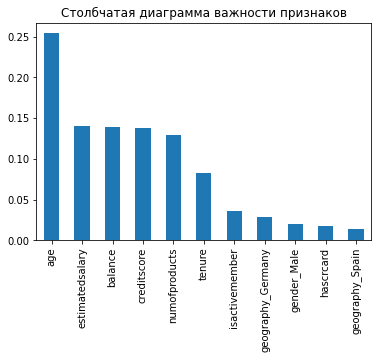

In [24]:
# Изучим важность признаков.
importance(model)

### Вывод

Наша модель случайного леса показала успешный результат: требуемое значение F1-меры достигнуто — 0,592.  
Параметры нашей модели:  
1. Алгоритм: случайный лес
2. Гиперпараметры: random_state=12345, n_estimators=38
3. Наборы features и target обработаны техникой OHE. Численные данные стандартизированы
4. Дисбаланс учтен при помощи техники Upsampling  
  
Благодаря атрибуту feature_importances мы выяснили, какие признакие наиболее тесно связаны с целевым признаком, а какие нет.  
Так, признак creditscore крайне важен для прогнозов, которые осуществляет наша модель. Это означает, что мы должны следить за качеством собираемых данных для этого признака.  
Наименее важными признаками оказались hascrcard, geography_Germany, geography_Spain, gender_Male. В целом мы можем удалить объекты этих признаков из нашего датасета, чтобы улучшить работу нашей модели.
  
Теперь изучим метрику AUC-ROC

## Изучение метрики AUC-ROC

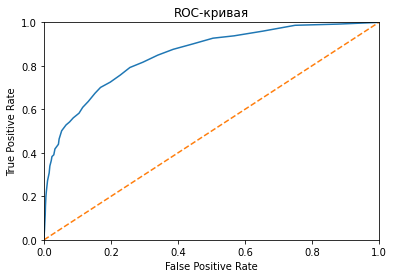


Значение AUC-ROC составляет 0.8509882888101976


In [25]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC-кривая')
plt.show()
print()
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Значение AUC-ROC составляет', auc_roc)

### Вывод

Значение AUC-ROC составило 0,851, что значительно больше 0,5. Напомним, что значение F1-меры составило 0,592.  
Данные значения являются относительно высокими, что означает относительно высокое качество нашей модели даже при различных значений порогов классификации.

## Общий вывод

Нами была построена модель, позволяющая с довольно высоким качеством определить уйдет клиент из банка в ближайшее время или нет.  
Мы успешно подготовили данные, провели борьбу с дисбалансом и обеспечили необходимые значения основных метрик:  
* F1-мера составила 0,592
* AUC-ROC составило 0,851  

Относительно высокие значения основных метрик говорят нам о довольно высоком качестве нашей модели.
